<a href="https://colab.research.google.com/github/mi622/EDP/blob/main/Diferencias_Progresivas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================================
# Ecuación del Calor 1D — Diferencias progresivas (FTCS)
# Problema de clase:
#   u_t - u_xx = 0,  0 < x < 1,  t >= 0
#   u(0,t) = u(1,t) = 0
#   u(x,0) = sin(pi x)
# Comparar en t = 0.5
# Casos:
#   (a) h = 0.1, k = 0.0005   -> r = k/h^2 = 0.05 (estable)
#   (b) h = 0.1, k = 0.01     -> r = 1.00 (INestable para FTCS)
#
# Incluye:
#   a) Documentación/comentarios
#   b) Comparación TABULAR vs solución analítica (incluye tabla conjunta como la de la imagen)
#   c) Comparación GRÁFICA numérica vs analítica
#   d) Comentario de diferencias al variar h y k (estabilidad y error)
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Solución analítica
# --------------------------------------------------------------
def u_exact(x, t):
    """Solución exacta: u(x,t) = exp(-pi^2 t) * sin(pi x)."""
    return np.exp(-(np.pi**2)*t) * np.sin(np.pi*x)

# --------------------------------------------------------------
# Esquema FTCS (Forward-Time Central-Space)
# --------------------------------------------------------------
def heat_ftcs(h, k, t_final=0.5, allow_unstable=False):
    """
    Resuelve la ecuación del calor 1D en (0,1) con FTCS.
      - h: paso espacial
      - k: paso temporal
      - t_final: tiempo final
      - allow_unstable: si False, detiene si r>0.5 (inestable).
    Retorna:
      x (malla), u (matriz len(x) x len(t)), t (vector de tiempos), r = k/h^2
    """
    r = k/(h**2)
    if (r > 0.5) and (not allow_unstable):
        raise ValueError(f"FTCS inestable: r={r:.3f} > 0.5. Use allow_unstable=True para ejecutar igualmente.")

    # Malla espacial (incluye 0 y 1 con paso h)
    x = np.arange(0.0, 1.0 + 1e-12, h)

    # Malla temporal
    Nt = int(np.ceil(t_final/k))
    t = np.arange(0, Nt+1) * k
    # Si por redondeo no se llega exacto a t_final, lo aseguramos
    if t[-1] < t_final - 1e-14:
        t = np.append(t, t_final)

    # Inicialización u(x,0) = sin(pi x), y fronteras 0
    u = np.zeros((len(x), len(t)))
    u[:, 0] = np.sin(np.pi * x)
    u[0, :]  = 0.0
    u[-1, :] = 0.0

    # Avance en tiempo
    for n in range(len(t) - 1):
        u[1:-1, n+1] = u[1:-1, n] + r * (u[2:, n] - 2*u[1:-1, n] + u[:-2, n])

    return x, u, t, r

In [2]:
# --------------------------------------------------------------
# Utilidad para correr un caso y devolver tabla/errores
# --------------------------------------------------------------
def run_case(h, k, t_final=0.5, allow_unstable=False):
    x, u, t, r = heat_ftcs(h, k, t_final, allow_unstable=allow_unstable)
    u_num = u[:, -1]
    u_ex  = u_exact(x, t[-1])
    err   = np.abs(u_num - u_ex)
    df = pd.DataFrame({
        "x": x,
        "u_num(t_final)": u_num,
        "u_exact(t_final)": u_ex,
        "abs_error": err
    })
    linf = float(np.max(err))
    l2   = float(np.sqrt(np.trapz(err**2, x)))
    return x, u_num, u_ex, df, r, linf, l2


In [3]:
# ==============================================================
# (a) h=0.1, k=0.0005 (estable)
# ==============================================================
h_a, k_a = 0.1, 0.0005
xa, una, uea, dfa, ra, linfa, l2a = run_case(h_a, k_a, t_final=0.5, allow_unstable=False)
print(f"(a) r = {ra:.3f}, Nx = {len(xa)}, Nt = {int(0.5/k_a)}")
print(f"(a) ||e||_inf = {linfa:.6e},  ||e||_2 ≈ {l2a:.6e}")

# Vista rápida de la tabla del caso (a)
dfa


(a) r = 0.050, Nx = 11, Nt = 1000
(a) ||e||_inf = 2.074533e-04,  ||e||_2 ≈ 1.466917e-04


/tmp/ipython-input-4018333300.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  l2   = float(np.sqrt(np.trapz(err**2, x)))


,x,u_num(t_final),u_exact(t_final),abs_error
0,0.0,0.000000,0.000000e+00,0.000000e+00
1,0.1,0.002287,2.222414e-03,6.410661e-05
2,0.2,0.004349,4.227283e-03,1.219380e-04
3,0.3,0.005986,5.818356e-03,1.678333e-04
4,0.4,0.007037,6.839888e-03,1.972999e-04
5,0.5,0.007399,7.191883e-03,2.074533e-04
6,0.6,0.007037,6.839888e-03,1.972999e-04
7,0.7,0.005986,5.818356e-03,1.678333e-04
8,0.8,0.004349,4.227283e-03,1.219380e-04
9,0.9,0.002287,2.222414e-03,6.410661e-05


In [4]:

# ==============================================================
# (b) h=0.1, k=0.01 (INestable) — ejecutado solo con allow_unstable=True
# ==============================================================/
h_b, k_b = 0.1, 0.01
xb, unb, ueb, dfb, rb, linfb, l2b = run_case(h_b, k_b, t_final=0.5, allow_unstable=True)
print(f"(b) r = {rb:.3f}, Nx = {len(xb)}, Nt = {int(0.5/k_b)}")
print(f"(b) ||e||_inf = {linfb:.6e},  ||e||_2 ≈ {l2b:.6e}")

# Vista rápida de la tabla del caso (b)
dfb


(b) r = 1.000, Nx = 11, Nt = 50
(b) ||e||_inf = 1.364788e+05,  ||e||_2 ≈ 9.444030e+04


/tmp/ipython-input-4018333300.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  l2   = float(np.sqrt(np.trapz(err**2, x)))


,x,u_num(t_final),u_exact(t_final),abs_error
0,0.0,0.000000,0.000000e+00,0.000000e+00
1,0.1,-30266.270026,2.222414e-03,3.026627e+04
2,0.2,60588.054981,4.227283e-03,6.058805e+04
3,0.3,-89862.842345,5.818356e-03,8.986285e+04
4,0.4,115225.537917,6.839888e-03,1.152255e+05
5,0.5,-132328.392814,7.191883e-03,1.323284e+05
6,0.6,136478.815915,6.839888e-03,1.364788e+05
7,0.7,-124251.368517,5.818356e-03,1.242514e+05
8,0.8,94976.581153,4.227283e-03,9.497658e+04
9,0.9,-51519.548023,2.222414e-03,5.151955e+04


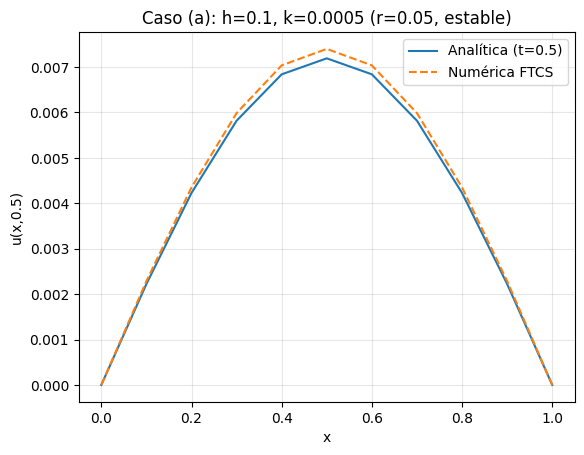

In [5]:
# ==============================================================
# (c) Gráficas comparativas en t = 0.5 (una por caso)
# ==============================================================

# Caso (a)
plt.figure()
plt.plot(xa, uea, label="Analítica (t=0.5)")
plt.plot(xa, una, "--", label="Numérica FTCS")
plt.xlabel("x")
plt.ylabel("u(x,0.5)")
plt.title("Caso (a): h=0.1, k=0.0005 (r=0.05, estable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

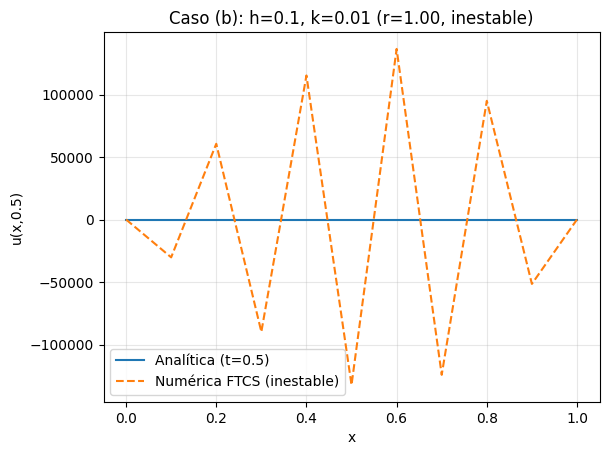

In [6]:

# Caso (b)
plt.figure()
plt.plot(xb, ueb, label="Analítica (t=0.5)")
plt.plot(xb, unb, "--", label="Numérica FTCS (inestable)")
plt.xlabel("x")
plt.ylabel("u(x,0.5)")
plt.title("Caso (b): h=0.1, k=0.01 (r=1.00, inestable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# ==============================================================
# (b-extra) TABLA CONJUNTA como en la imagen:
#   xi, u(xi,0.5), w_{i,1000} (k=0.0005), |u - w_{i,1000}|,
#                     w_{i,50} (k=0.01),  |u - w_{i,50}|
#   Nota: con h=0.1, los nodos son xi = 0.0, 0.1, ..., 1.0
# ==============================================================

def fmt_sci(x, sig=4):
    """Formatea en notación científica tipo a × 10^b."""
    if x == 0:
        return "0"
    s = f"{x:.{sig}e}"   # ejemplo: -1.2345e+06
    mant, exp = s.split("e")
    exp = int(exp)
    # Quitar ceros de la mantisa al final
    mant = mant.rstrip("0").rstrip(".")
    return f"{mant} × 10^{exp}"


In [8]:

# Construir DataFrame conjunto
xi = xa  # (mismos nodos para ambos casos porque h=0.1)
table_joint = pd.DataFrame({
    r"x_i": xi,
    r"u(x_i,0.5)": uea,                 # analítica
    r"w_{i,1000} (k=0.0005)": una,      # numérica estable
    r"|u - w_{i,1000}|": np.abs(uea - una),
    r"w_{i,50}$ (k=0.01)": unb,          # numérica inestable
    r"|u - w_{i,50}|": np.abs(uea - unb)
})


In [9]:
table_pretty = pd.DataFrame({
    r"x_i": [f"{v:.1f}" for v in xi],
    r"u(x_i,0.5)":       [fmt_sci(v, sig=6) for v in uea],
    r"w_{i,1000} (k=0.0005)": [fmt_sci(v, sig=6) for v in una],
    r"|u - w_{i,1000}|": [fmt_sci(v, sig=3) for v in np.abs(uea - una)],
    r"w_{i,50} (k=0.01)":    [fmt_sci(v, sig=6) for v in unb],
    r"|u - w_{i,50}|": [fmt_sci(v, sig=3) for v in np.abs(uea - unb)],
})

# Muestra la tabla
table_pretty

,x_i,"u(x_i,0.5)","w_{i,1000} (k=0.0005)","|u - w_{i,1000}|","w_{i,50} (k=0.01)","|u - w_{i,50}|"
0,0.0,0,0,0,0,0
1,0.1,2.222414 × 10^-3,2.286521 × 10^-3,6.411 × 10^-5,-3.026627 × 10^4,3.027 × 10^4
2,0.2,4.227283 × 10^-3,4.349221 × 10^-3,1.219 × 10^-4,6.058805 × 10^4,6.059 × 10^4
3,0.3,5.818356 × 10^-3,5.986189 × 10^-3,1.678 × 10^-4,-8.986284 × 10^4,8.986 × 10^4
4,0.4,6.839888 × 10^-3,7.037187 × 10^-3,1.973 × 10^-4,1.152255 × 10^5,1.152 × 10^5
5,0.5,7.191883 × 10^-3,7.399337 × 10^-3,2.075 × 10^-4,-1.323284 × 10^5,1.323 × 10^5
6,0.6,6.839888 × 10^-3,7.037187 × 10^-3,1.973 × 10^-4,1.364788 × 10^5,1.365 × 10^5
7,0.7,5.818356 × 10^-3,5.986189 × 10^-3,1.678 × 10^-4,-1.242514 × 10^5,1.243 × 10^5
8,0.8,4.227283 × 10^-3,4.349221 × 10^-3,1.219 × 10^-4,9.497658 × 10^4,9.498 × 10^4
9,0.9,2.222414 × 10^-3,2.286521 × 10^-3,6.411 × 10^-5,-5.151955 × 10^4,5.152 × 10^4


In [10]:
# Resumen de errores de ambos casos
summary = pd.DataFrame([
    {"caso": "(a)", "h": h_a, "k": k_a, "r": ra, "Linf": linfa, "L2": l2a},
    {"caso": "(b)", "h": h_b, "k": k_b, "r": rb, "Linf": linfb, "L2": l2b},
])
summary

,caso,h,k,r,Linf,L2
0,(a),0.1,0.0005,0.05,0.000207,0.000147
1,(b),0.1,0.0100,1.00,136478.809075,94440.300001
